C:\Users\jaywa\AppData\Local\Temp\ipykernel_33784\2847939602.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weights_df['Period'] = pd.to_datetime(weights_df['Period'], errors='coerce').dt.to_period('M')


          Date  Portfolio_Return  Cumulative_Return
0   2024-08-01         -0.003397           0.996603
1   2024-08-01         -0.009234           0.987400
2   2024-08-02         -0.010520           0.977013
3   2024-08-02          0.015531           0.992187
4   2024-08-05         -0.014994           0.977310
..         ...               ...                ...
199 2025-02-24          0.000234           1.104537
200 2025-02-25         -0.003478           1.100695
201 2025-02-26          0.002118           1.103027
202 2025-02-27         -0.008799           1.093321
203 2025-02-28          0.001435           1.094891

[204 rows x 3 columns]


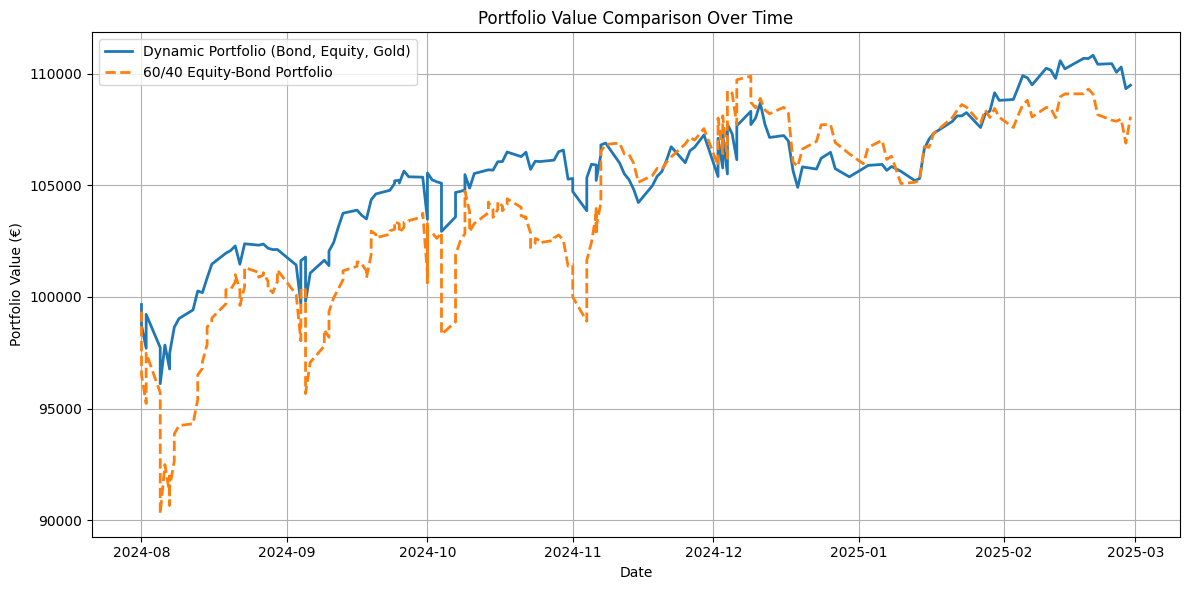

In [ ]:
import pandas as pd
import numpy  as np

# --- Step 1: Load the data ---

# MVO allocatuion of assets
mvo_allocation = ""
# Load price data
historical_data_prices_of_all_assets = ""
price_df = pd.read_csv(historical_data_prices_of_all_assets, parse_dates=['Date'])
price_df = price_df.sort_values('Date')

# Calculate daily returns
returns_df = price_df.copy()
returns_df[['Bond', 'Equity', 'Gold']] = returns_df[['Bond', 'Equity', 'Gold']].pct_change()
returns_df['Month'] = returns_df['Date'].dt.to_period('M')

# Load weights
weights_df = pd.read_csv(mvo_allocation)
weights_df['Period'] = pd.to_datetime(weights_df['Period'], errors='coerce').dt.to_period('M')

weights_df = weights_df.rename(columns={
    'Bond Weight': 'Bond',
    'Equity Weight': 'Equity',
    'Golds Weight': 'Gold'
})
weights_df = weights_df.set_index('Period')

# --- Step 2: Calculate portfolio returns with monthly rebalancing ---
portfolio_returns = []
current_weights = None
last_month = None

for i in range(1, len(returns_df)):
    row = returns_df.iloc[i]
    this_month = row['Month']

    # If new month, rebalance using new weights
    if this_month != last_month:
        if this_month in weights_df.index:
            current_weights = weights_df.loc[this_month].to_dict()
        else:
            # If month not in weights, use previous weights
            current_weights = current_weights
        last_month = this_month

    if current_weights:
        port_ret = (
            row['Bond'] * current_weights['Bond'] +
            row['Equity'] * current_weights['Equity'] +
            row['Gold'] * current_weights['Gold']
        )
        portfolio_returns.append({
            'Date': row['Date'],
            'Portfolio_Return': port_ret
        })

# --- Step 3: Create DataFrame and compute cumulative return ---
portfolio_df = pd.DataFrame(portfolio_returns)
portfolio_df['Cumulative_Return'] = (1 + portfolio_df['Portfolio_Return']).cumprod()

# Display the result
print(portfolio_df)
# Add starting value
initial_value = 100000

# Compute daily portfolio value from cumulative return
portfolio_df['Portfolio_Value'] = initial_value * portfolio_df['Cumulative_Return']

# Create second portfolio (Bond 60%, Equity 40%)
second_portfolio_returns = []
last_month = None

for i in range(1, len(returns_df)):
    row = returns_df.iloc[i]
    this_month = row['Month']

    # Rebalance on first day of each month (fixed 60/40)
    if this_month != last_month:
        current_weights_2 = {'Equity': 0.6, 'Bond': 0.4}
        last_month = this_month

    port_ret_2 = (
        row['Bond'] * current_weights_2['Bond'] +
        row['Equity'] * current_weights_2['Equity']
    )

    second_portfolio_returns.append({
        'Date': row['Date'],
        'Portfolio_Return_2': port_ret_2
    })

# Merge second portfolio return into main DataFrame
second_portfolio_df = pd.DataFrame(second_portfolio_returns)
portfolio_df = pd.merge(portfolio_df, second_portfolio_df, on='Date', how='left')

# Compute cumulative return and value for second portfolio
portfolio_df['Cumulative_Return_2'] = (1 + portfolio_df['Portfolio_Return_2']).cumprod()
portfolio_df['Portfolio_Value_2'] = initial_value * portfolio_df['Cumulative_Return_2']

import matplotlib.pyplot as plt

# Plot both portfolios
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df['Date'], portfolio_df['Portfolio_Value'], label='Dynamic Portfolio (Bond, Equity, Gold)', linewidth=2)
plt.plot(portfolio_df['Date'], portfolio_df['Portfolio_Value_2'], label='60/40 Equity-Bond Portfolio', linestyle='--', linewidth=2)
plt.title('Portfolio Value Comparison Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (€)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Save to CSV
# portfolio_df.to_csv('simulated_portfolio.csv', index=False)
# Create a new DataFrame with daily returns of both portfolios
daily_returns_df = pd.DataFrame({
    'Date': portfolio_df['Date'],
    'MVO_Portfolio_Return': portfolio_df['Portfolio_Return'],
    '6040_Portfolio_Return': portfolio_df['Portfolio_Return_2']
})

# Display the first few rows
print(daily_returns_df.head())


# Calculate performance metrics
def calculate_metrics(returns, name):
    total_return = (1 + returns).prod() - 1
    annualized_return = (1 + total_return) ** (12 / 7) - 1
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)  # Annualized
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    return {
        'Portfolio': name,
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }

# Calculate metrics for both portfolios
mvo_metrics = calculate_metrics(daily_returns_df['MVO_Portfolio_Return'], 'MVO Portfolio')
sixty_forty_metrics = calculate_metrics(daily_returns_df['6040_Portfolio_Return'], '60/40 Portfolio')

# Combine results into a DataFrame
metrics_df = pd.DataFrame([mvo_metrics, sixty_forty_metrics])

# Display results
print(metrics_df)
